In [1]:
from skimage import img_as_float, img_as_ubyte
from skimage.io import imread, imsave, imshow

In [2]:
import numpy as np
import numpy.fft
from scipy import misc
from scipy.ndimage import convolve
from scipy.signal import convolve2d, correlate2d
import scipy.fftpack as fp

In [3]:
from scipy.signal import convolve2d, correlate2d, fftconvolve
from scipy.signal.windows import gaussian
import matplotlib.pyplot as plt
from skimage import exposure

## Question 1a

In [4]:
def fft_convolve(f_img,kernal):
    M,N = f_img.shape
    m,n = kernal.shape
    
    P = M + (m-1)
    Q = N + (n-1)
    g_img = np.pad(f_img,[[0,P-M],[0,Q-N]])
    g_kernal = np.pad(kernal,[[0,P-m],[0,Q-n]])
    
    G_img = fp.fft2(g_img)
    G_kernal = fp.fft2(g_kernal)
    
    H_img = G_img * G_kernal
    
    h_img = np.real(fp.ifft2(H_img))
    h_img = np.copy(h_img[(m-1)//2:((m-1)//2)+M  ,(n-1)//2:((n-1)//2)+N])      # Care when cropping that the padding comes back evenly spaced around the image
    
    return h_img

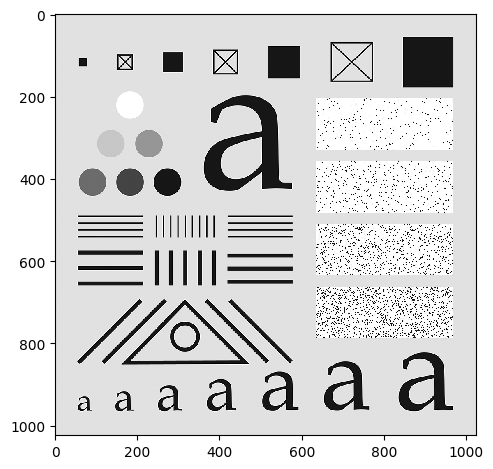

In [5]:
f_test = img_as_float(imread("data/labE_images/testpattern1024.tif"))
imshow(f_test, cmap='gray')

In [6]:
ss = 13
sd = 2

gauss_kernel = np.outer(gaussian(ss,sd), gaussian(ss,sd))
gauss_kernel = gauss_kernel/np.sum(gauss_kernel)

In [7]:
g_test_1 = fft_convolve(f_test,gauss_kernel)
g_test_2 = fftconvolve(f_test, gauss_kernel, mode='same')

/home/marcelln/Digital-Image-Processing/.venv/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


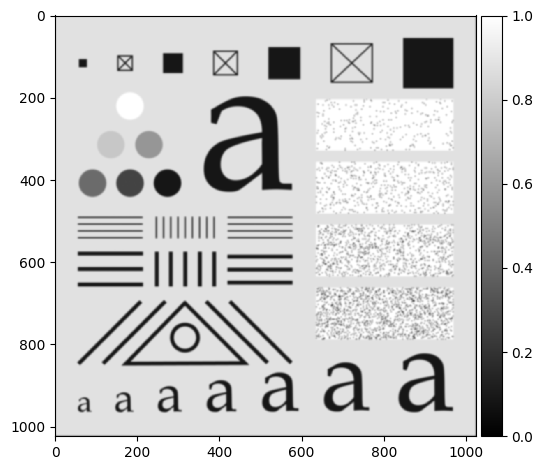

In [8]:
imshow(g_test_1, cmap='gray',vmin=0,vmax=1)

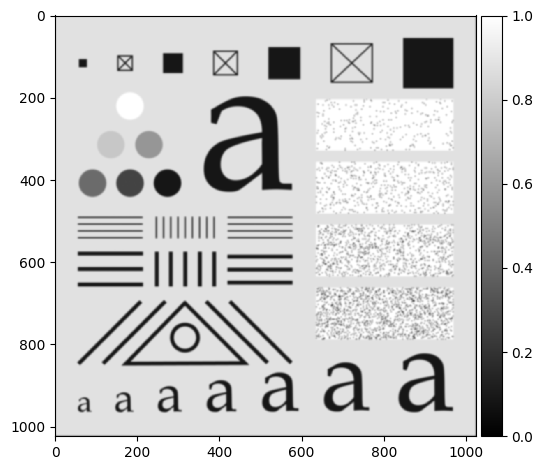

In [9]:
imshow(g_test_2, cmap='gray',vmin=0,vmax=1)

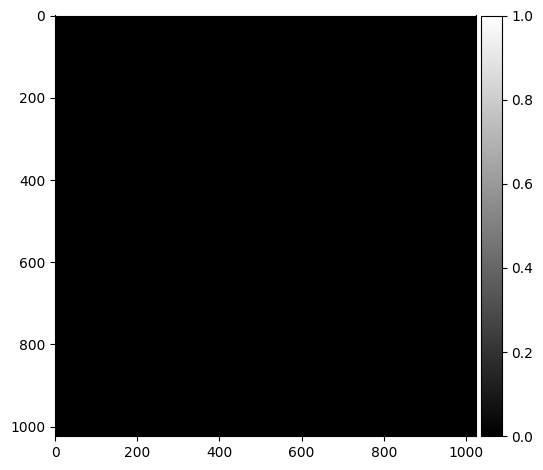

In [10]:
imshow(g_test_2-g_test_1, cmap='gray',vmin=0,vmax=1)

## Question 1b

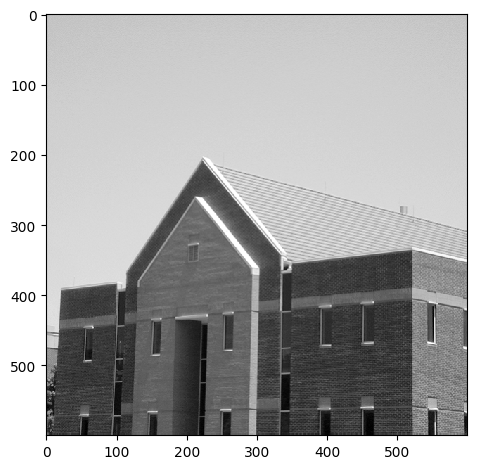

In [11]:
f_house = img_as_float(imread("data/labE_images/house.tif"))
imshow(f_house, cmap='gray')

In [12]:
sobel   = np.array([[-1,0,1],
                    [-2,0,2],
                    [-1,0,1]])

g_house = fft_convolve(f_house,sobel)
#g_house = fftconvolve(f_house, sobel, mode='same')

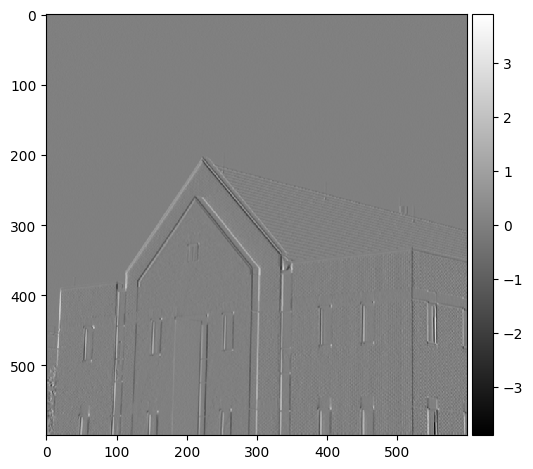

In [13]:
imshow(g_house, cmap='gray')

## Question 2a

In [14]:
def f_filter(m,n,type,param):
    f_filter = np.zeros([m,n])
    
    u = np.arange(0,m)
    v = np.arange(0,n)

    idx = np.where(u>m/2)
    u[idx] = u[idx] - m

    idy = np.where(v>n/2)
    v[idy] = v[idy] - n    

    V,U = np.meshgrid(v,u)               # Note v vs u first
    D = np.sqrt(V**2+U**2)
    D = fp.fftshift(D)                   # Filter radius
        
    if type == 'ILPF':
        idx = np.where(D<=param)
        f_filter[idx] = 1
        
    elif type == 'GLPF':
        f_filter = np.exp((-D**2)/(2*param**2))
    
    elif type == 'BLPF':
        n = 2
        f_filter=1/(1+(D/param)**(2*n))
        
    elif type == 'IHPF':
        idx = np.where(D>param)
        f_filter[idx] = 1
 
    else:
        print("type must be 'ILPF','GLPF','BLPF','IHPF'")
    
    return f_filter

In [15]:
a = f_filter(10,10,'ILPF',3)

In [16]:
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## Question 2b

In [17]:
def band_filter(m,n,type,param,w):
    f_filter = np.ones([m,n])
    
    u = np.arange(0,m)
    v = np.arange(0,n)

    idx = np.where(u>m/2)
    u[idx] = u[idx] - m

    idy = np.where(v>n/2)
    v[idy] = v[idy] - n    

    U,V = np.meshgrid(u,v)
    D = np.sqrt(V**2+U**2)
    D = fp.fftshift(D)
        
    if type == 'IBRF':
        idx = np.where(((param-w/2)<=D) & (D<=(param+w/2)))
        f_filter[idx] = 0
        
    elif type == 'GBRF':
        f_filter = 1-np.exp(-((D**2-param**2)/(w*D))**2)
    
    elif type == 'BBRF':
        n = 20
        f_filter=1/(1+(w*D/(D**2-param**2))**(2*n))
 
    else:
        print("type must be 'ILPF','GLPF','BLPF','IHPF'")
    
    return f_filter

In [18]:
m = 256*2
n = 256*2
D0 = 80
w = 40

In [19]:
filter_a = f_filter(m,n,'ILPF',D0)
filter_b = f_filter(m,n,'BLPF',D0)
filter_c = f_filter(m,n,'GLPF',D0)
filter_d = 1-f_filter(m,n,'ILPF',D0)
filter_e = 1-f_filter(m,n,'BLPF',D0)
filter_f = 1-f_filter(m,n,'GLPF',D0)
filter_g = band_filter(m,n,'IBRF',D0,w)
filter_h = band_filter(m,n,'BBRF',D0,w)
filter_i = band_filter(m,n,'GBRF',D0,w)
filter_j = 1-band_filter(m,n,'IBRF',D0,w)
filter_k = 1-band_filter(m,n,'BBRF',D0,w)
filter_l = 1-band_filter(m,n,'GBRF',D0,w)

/tmp/ipykernel_19615/1093090272.py:26: RuntimeWarning: divide by zero encountered in divide
  f_filter=1/(1+(w*D/(D**2-param**2))**(2*n))
/tmp/ipykernel_19615/1093090272.py:22: RuntimeWarning: divide by zero encountered in divide
  f_filter = 1-np.exp(-((D**2-param**2)/(w*D))**2)


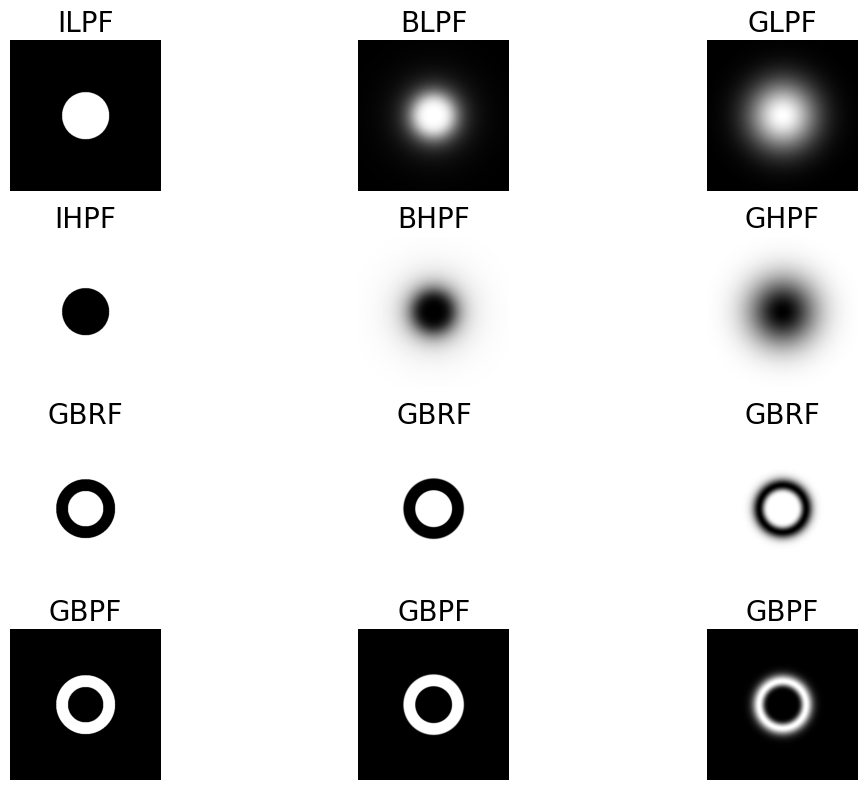

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8), sharex=True, sharey=True)            
plt.subplot(4,3,1), plt.imshow(filter_a, cmap=plt.cm.gray)
plt.title('ILPF', size=20), plt.axis('off')
plt.subplot(4,3,2), plt.imshow(filter_b, cmap=plt.cm.gray)
plt.title('BLPF', size=20), plt.axis('off')
plt.subplot(4,3,3), plt.imshow(filter_c, cmap='gray')
plt.title('GLPF', size=20), plt.axis('off')
plt.subplot(4,3,4), plt.imshow(filter_d, cmap=plt.cm.gray)
plt.title('IHPF', size=20), plt.axis('off')
plt.subplot(4,3,5), plt.imshow(filter_e, cmap=plt.cm.gray)
plt.title('BHPF', size=20), plt.axis('off')
plt.subplot(4,3,6), plt.imshow(filter_f, cmap=plt.cm.gray)
plt.title('GHPF', size=20), plt.axis('off')
plt.subplot(4,3,7), plt.imshow(filter_g, cmap=plt.cm.gray)
plt.title('GBRF', size=20), plt.axis('off')
plt.subplot(4,3,8), plt.imshow(filter_h, cmap=plt.cm.gray)
plt.title('GBRF', size=20), plt.axis('off')
plt.subplot(4,3,9), plt.imshow(filter_i, cmap=plt.cm.gray)
plt.title('GBRF', size=20), plt.axis('off')
plt.subplot(4,3,10), plt.imshow(filter_j, cmap=plt.cm.gray)
plt.title('GBPF', size=20), plt.axis('off')
plt.subplot(4,3,11), plt.imshow(filter_k, cmap=plt.cm.gray)
plt.title('GBPF', size=20), plt.axis('off')
plt.subplot(4,3,12), plt.imshow(filter_l, cmap=plt.cm.gray)
plt.title('GBPF', size=20), plt.axis('off')

plt.tight_layout()
plt.show()

## Question 2c

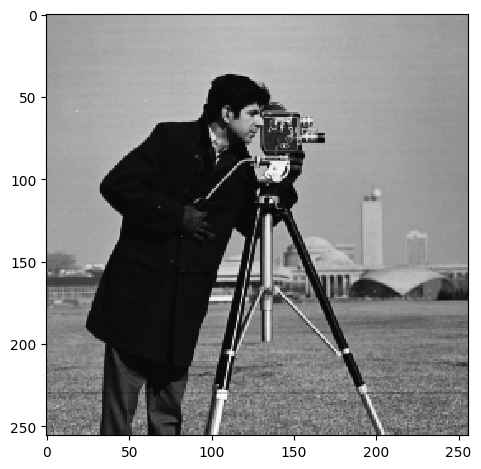

In [21]:
f_man= img_as_float(imread("data/labE_images/cameraman.tif"))
imshow(f_man, cmap='gray')

In [22]:
def freq_filter(f_img,tf):
    M,N = f_img.shape
    m,n = tf.shape
    
    P = M*2
    Q = N*2
    g_img = np.pad(f_img,[[0,P-M],[0,Q-N]])
    
    G_img = fp.fftshift(fp.fft2(g_img))
    
    H_img = G_img * tf
    
    h_img = np.real(fp.ifft2(fp.ifftshift(H_img)))
    h_img = np.copy(h_img[0:M, 0:N])      # Care when cropping that the padding comes back evenly spaced around the image
    
    return h_img

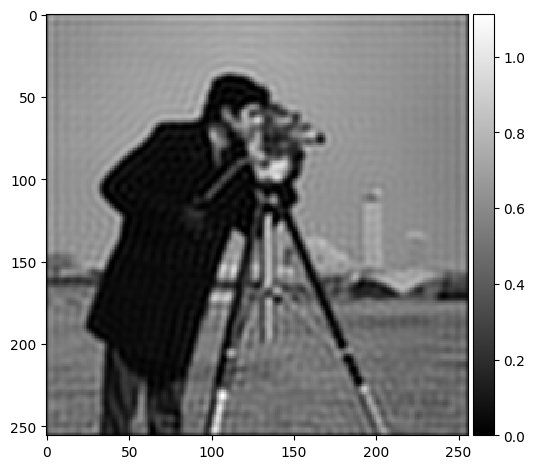

In [23]:
imshow(freq_filter(f_man,filter_a), cmap='gray', vmin=0)

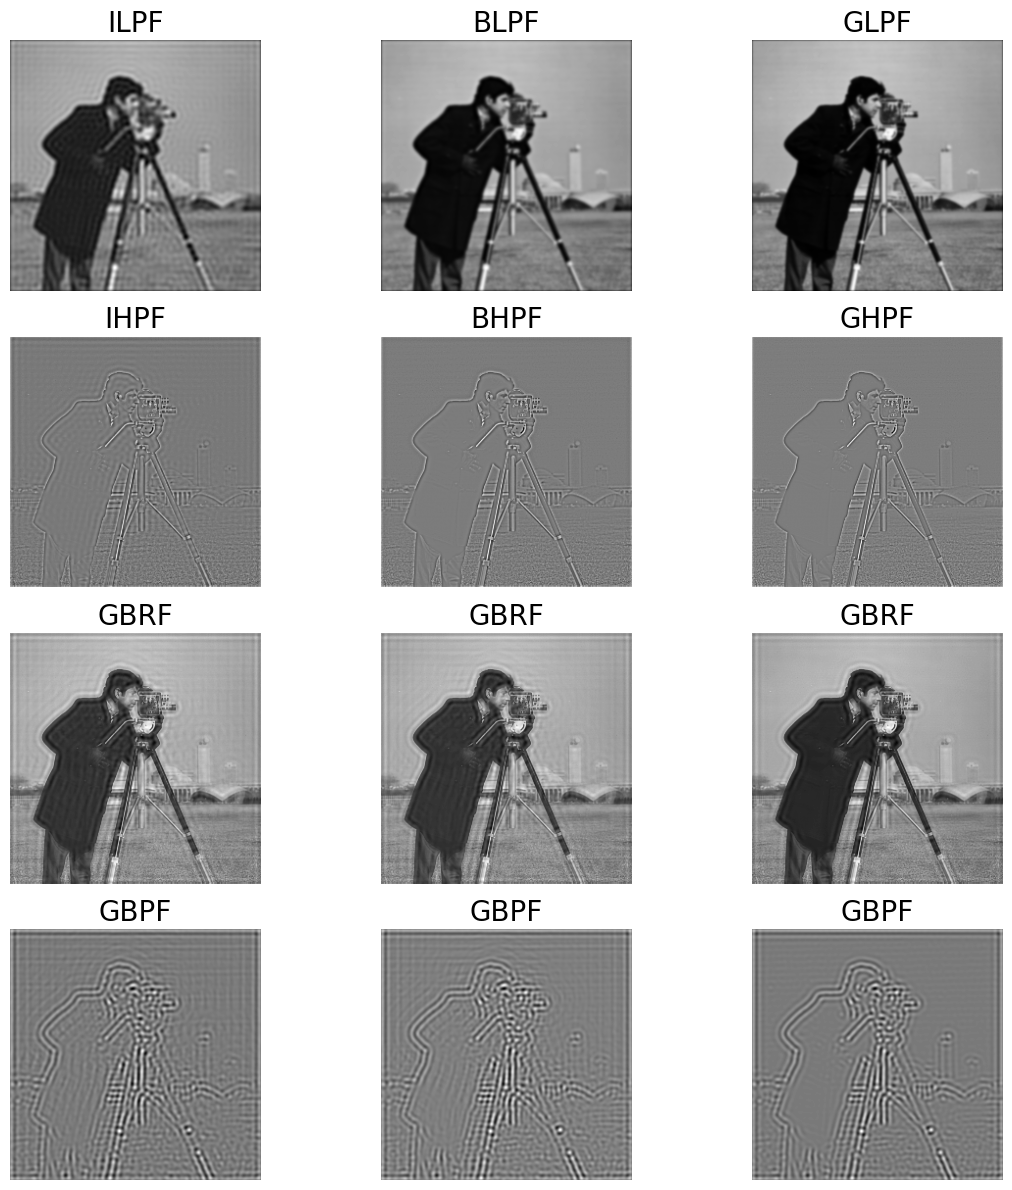

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12), sharex=True, sharey=True)            
plt.subplot(4,3,1), plt.imshow(freq_filter(f_man,filter_a), cmap=plt.cm.gray)
plt.title('ILPF', size=20), plt.axis('off')
plt.subplot(4,3,2), plt.imshow(freq_filter(f_man,filter_b), cmap=plt.cm.gray)
plt.title('BLPF', size=20), plt.axis('off')
plt.subplot(4,3,3), plt.imshow(freq_filter(f_man,filter_c), cmap='gray')
plt.title('GLPF', size=20), plt.axis('off')
plt.subplot(4,3,4), plt.imshow(freq_filter(f_man,filter_d), cmap=plt.cm.gray)
plt.title('IHPF', size=20), plt.axis('off')
plt.subplot(4,3,5), plt.imshow(freq_filter(f_man,filter_e), cmap=plt.cm.gray)
plt.title('BHPF', size=20), plt.axis('off')
plt.subplot(4,3,6), plt.imshow(freq_filter(f_man,filter_f), cmap=plt.cm.gray)
plt.title('GHPF', size=20), plt.axis('off')
plt.subplot(4,3,7), plt.imshow(freq_filter(f_man,filter_g), cmap=plt.cm.gray)
plt.title('GBRF', size=20), plt.axis('off')
plt.subplot(4,3,8), plt.imshow(freq_filter(f_man,filter_h), cmap=plt.cm.gray)
plt.title('GBRF', size=20), plt.axis('off')
plt.subplot(4,3,9), plt.imshow(freq_filter(f_man,filter_i), cmap=plt.cm.gray)
plt.title('GBRF', size=20), plt.axis('off')
plt.subplot(4,3,10), plt.imshow(freq_filter(f_man,filter_j), cmap=plt.cm.gray)
plt.title('GBPF', size=20), plt.axis('off')
plt.subplot(4,3,11), plt.imshow(freq_filter(f_man,filter_k), cmap=plt.cm.gray)
plt.title('GBPF', size=20), plt.axis('off')
plt.subplot(4,3,12), plt.imshow(freq_filter(f_man,filter_l), cmap=plt.cm.gray)
plt.title('GBPF', size=20), plt.axis('off')

plt.tight_layout()
plt.show()

## Question 3

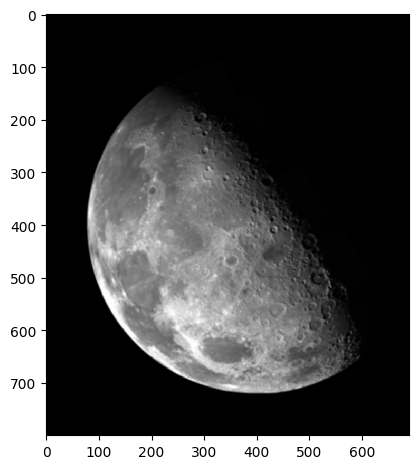

In [25]:
f_moon= img_as_float(imread("data/labE_images/blurry-moon.tif"))
imshow(f_moon, cmap='gray')

In [26]:
M,N = f_moon.shape
tf = f_filter(M*2,N*2,'GLPF',D0)

k=4
P = M*2
Q = N*2
g_moon = np.pad(f_moon,[[0,P-M],[0,Q-N]])

G_moon = fp.fftshift(fp.fft2(g_moon))

H_moon = G_moon*(k*(1-tf)+1)

h_moon = np.real(fp.ifft2(fp.ifftshift(H_moon)))
h_moon = np.copy(h_moon[0:M, 0:N])      # Care when cropping that the padding comes back evenly spaced around the image

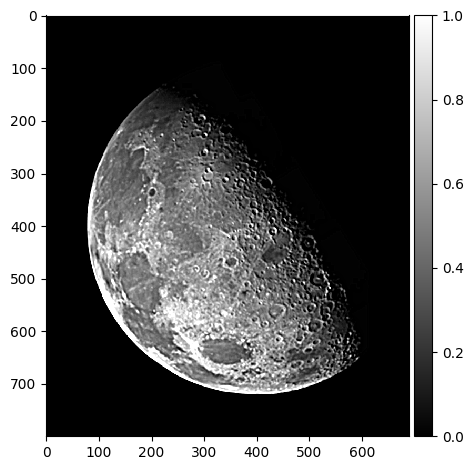

In [27]:
imshow(h_moon, cmap='gray',vmin=0,vmax=1)

## Question 4

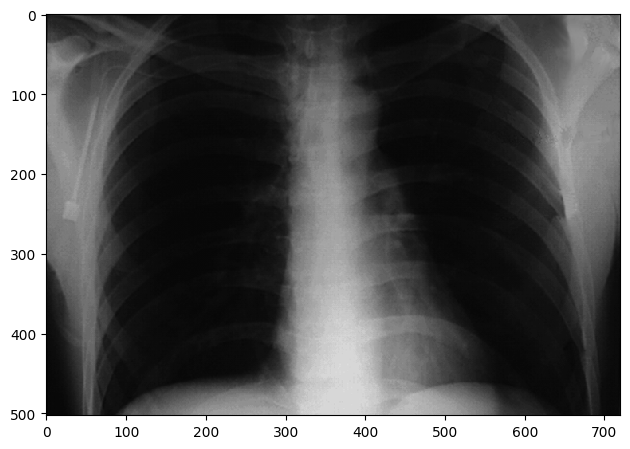

In [28]:
f_chest = img_as_float(imread("data/labE_images/chestXray.tif"))
imshow(f_chest, cmap='gray')

In [29]:
M,N = f_chest.shape
tf = 1-f_filter(M*2,N*2,'BLPF',M*0.05)

P = M*2
Q = N*2
g_chest = np.pad(f_chest,[[0,P-M],[0,Q-N]])

G_chest = fp.fftshift(fp.fft2(g_chest))

H_chest = G_chest*tf

h_chest = np.real(fp.ifft2(fp.ifftshift(H_chest)))
h_chest = np.copy(h_chest[0:M, 0:N])      

In [30]:
a = 0.5
b = 2

J_chest = G_chest*(a+b*tf)

j_chest = np.real(fp.ifft2(fp.ifftshift(J_chest)))
j_chest = np.copy(j_chest[0:M, 0:N])      

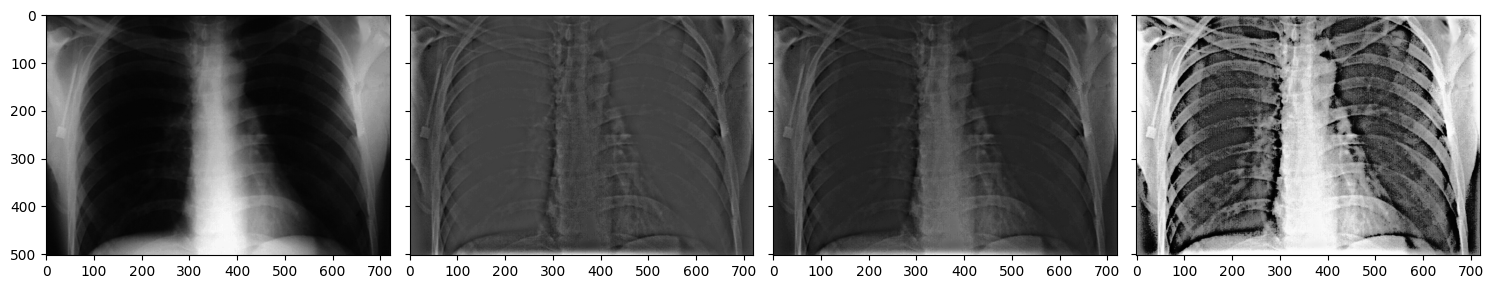

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15), sharex=True, sharey=True)            
plt.subplot(1,4,1), plt.imshow(f_chest, cmap=plt.cm.gray)
plt.subplot(1,4,2), plt.imshow(h_chest, cmap=plt.cm.gray)
plt.subplot(1,4,3), plt.imshow(j_chest, cmap='gray')
plt.subplot(1,4,4), plt.imshow(exposure.equalize_hist(j_chest), cmap=plt.cm.gray)

plt.tight_layout()
plt.show()

## Question 5

In [32]:
def laplacianTF(P,Q):
    h = np.array([[-1,-1,-1],
                  [-1, 9,-1],
                  [-1,-1,-1]])
    h = np.pad(h,[[0,P-3],[0,Q-3]])
    
    H = fp.fft2(h)
    return H

In [33]:
M,N = f_moon.shape
P = M+3
Q = N+3
x_moon = np.pad(f_moon,[[0,P-M],[0,Q-N]])
X_moon = fp.fft2(x_moon)
y_moon = np.real(fp.ifft2(X_moon*laplacianTF(P,Q)))

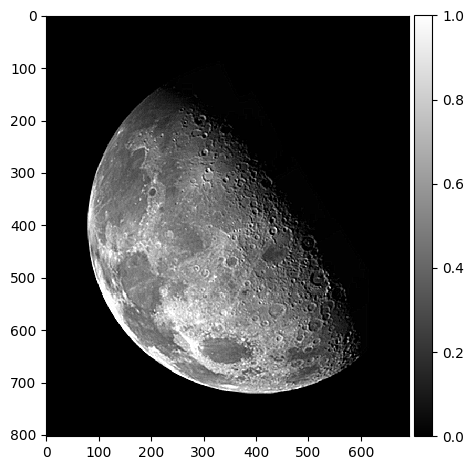

In [34]:
imshow(y_moon, cmap='gray',vmin=0,vmax=1)

## Question 6

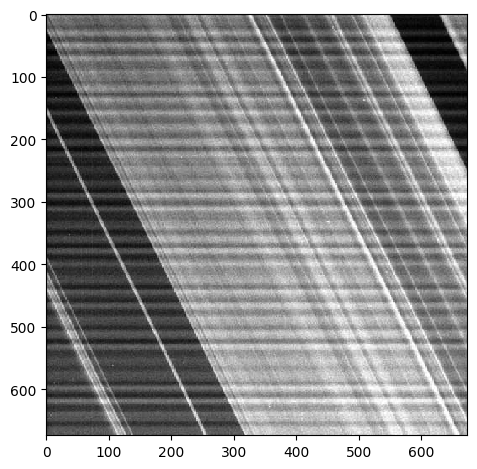

In [35]:
f_cass= img_as_float(imread("data/labE_images/cassini.tif"))
imshow(f_cass, cmap='gray')
M,N = f_cass.shape

In [36]:
f_cass.shape

(674, 674)

In [37]:
P = 2*M
Q = 2*N

f_cass = np.pad(f_cass,[[0,P-M],[0,Q-N]])
F_cass = fp.fftshift(fp.fft2(f_cass))

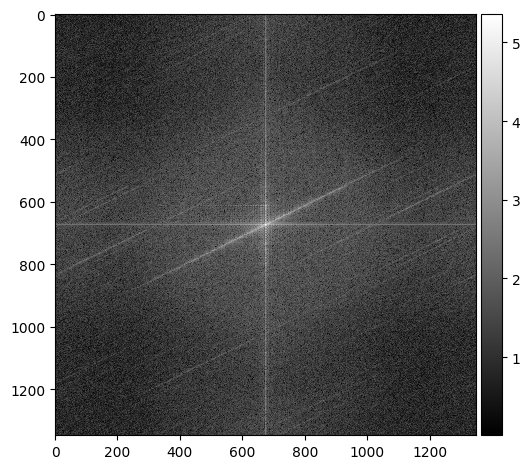

In [38]:
imshow(abs(np.log10(F_cass+1)), cmap='gray')

In [39]:
tf_filter = np.ones([P,Q])
t = 30
tf_filter[:,(Q//2)-t//2:(Q//2)+1+t//2] = 0
tf_filter[(P//2)-10:(P//2)+11,(Q//2)-t//2:(Q//2)+1+t//2] = 1

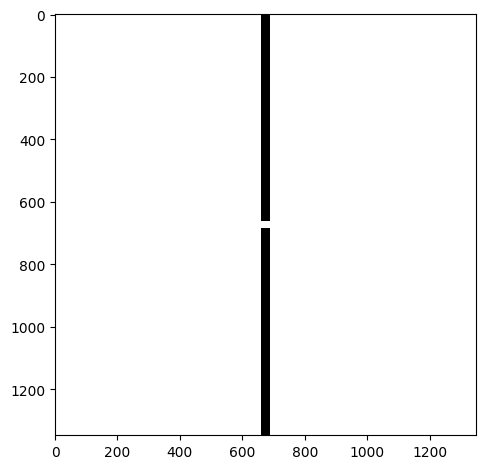

In [40]:
imshow(tf_filter, cmap='gray')

In [41]:
G_cass = F_cass * tf_filter
g_cass = np.real(fp.ifft2(fp.ifftshift(G_cass)))
g_cass = g_cass[0:M,0:N]

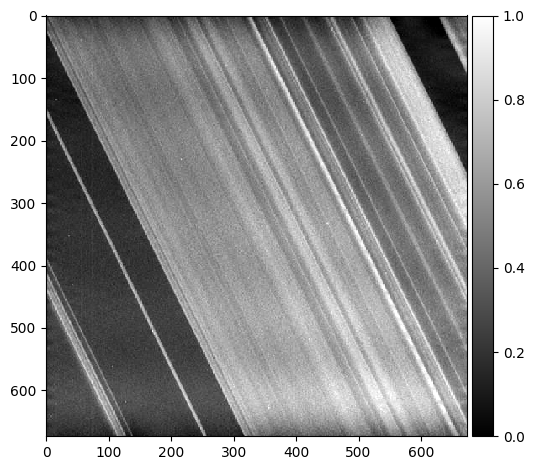

In [42]:
imshow(g_cass, cmap='gray',vmin=0,vmax=1)